# Demo Variogram with micro-lags

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

import data_utils
import spatial_tools
import fields
import variogram as vgm

In [4]:
ds = xr.open_dataset("../data/exp_pro/OCO2_4x5deg_monthly_conus_augmented.nc")

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]

var_names = ["xco2", "sif"]
cross_name = "xco2:sif"

In [10]:
lon_centers, lat_centers = data_utils.set_main_coords()
ds_main = data_utils.get_main_coords(ds, lon_centers, lat_centers)
ds_main

<xarray.Dataset>
Dimensions:   (lat: 10, lon: 13, time: 75)
Coordinates:
  * lon       (lon) float64 -125.0 -120.0 -115.0 -110.0 ... -75.0 -70.0 -65.0
  * lat       (lat) float64 22.0 26.0 30.0 34.0 38.0 42.0 46.0 50.0 54.0 58.0
  * time      (time) datetime64[ns] 2014-09-01 2014-10-01 ... 2020-11-01
Data variables:
    xco2      (lon, lat, time) float32 395.6965 nan 396.9703 ... 406.59906 nan
    xco2_var  (lon, lat, time) float32 0.8061755 nan 0.8937052 ... 1.1667289 nan
    sif       (lon, lat, time) float32 nan nan nan ... 0.022945013 nan
    sif_var   (lon, lat, time) float32 nan nan nan ... 0.14353608 0.19307406 nan

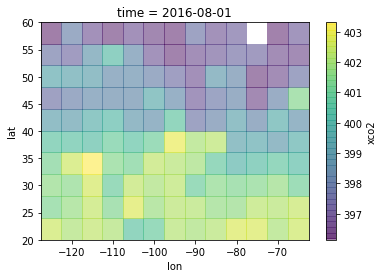

In [11]:
da = ds_main.xco2.sel(time="2016-08-01")
da.T.plot(alpha=0.5)

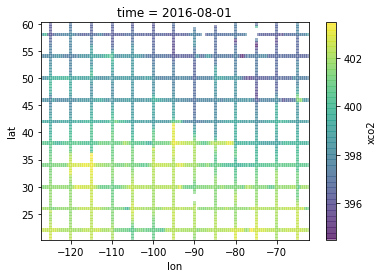

In [27]:
da = ds_xco2.xco2.sel(time="2016-08-01")
da.T.plot(alpha=0.5)

In [12]:
# Analysis variables
month = 8
timedelta = -2
n_bins = 50
fast_dist = True

timestamps = np.array(ds.time[ds.time.dt.month == month].values, dtype="datetime64[D]")

In [25]:
mf = fields.MultiField(ds_xco2, ds_sif, timestamps[1], timedelta=timedelta, fast_dist=fast_dist)

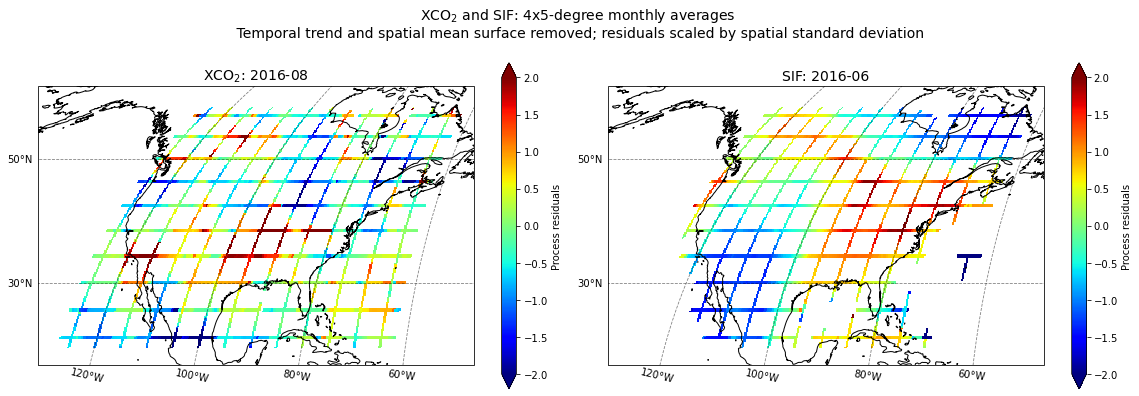

In [26]:
plot.plot_fields(mf)

In [81]:
# Apply microlag_clouds across lon_groups, concat each cloud type into it's own df (3 total), then append these dfs in empirical_variogram
df_ml = mf.field_1.df_micro.groupby(["lat", "lon_group"]).apply(vgm.microlag_clouds, "xco2")
# .reset_index().drop(columns=["lat", "lon_group", "level_2"]).dropna(subset=["distance"])

In [82]:
df_ml.head()

distance  variogram
lat  lon_group                         
14.0 -122.5    0   53.945971   0.038102
               1  107.891882   0.120336
               2  161.837673   0.104252
               3  215.783283   0.092698
               4   53.945971   0.023012

<AxesSubplot:xlabel='distance', ylabel='variogram_cross'>

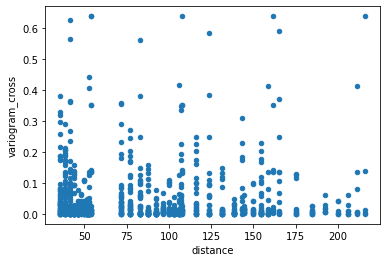

In [59]:
df_ml.plot(x="distance", y="variogram_cross", kind="scatter")